In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import image_dataset_from_directory

In [167]:
batch_size = 64
img_height = 40
img_width = 40

In [168]:
train_dir = 'C://Users//Games//Desktop//ML tutorial//CNN//Untitled Folder//data//train'
val_dir = 'C://Users//Games//Desktop//ML tutorial//CNN//Untitled Folder//data//valid'
test_dir = 'C://Users//Games//Desktop//ML tutorial//CNN//Untitled Folder//data//test'
train_ds = image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=(batch_size*2)
)
test_ds = image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 7629 files belonging to 10 classes.
Found 689 files belonging to 10 classes.
Found 381 files belonging to 10 classes.


In [169]:
class_names = test_ds.class_names

In [170]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 40, 40, 3)
(64, 10)


In [171]:
for image_batch, labels_batch in val_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(128, 40, 40, 3)
(128, 10)


In [172]:
for image_batch, labels_batch in test_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 40, 40, 3)
(64, 10)


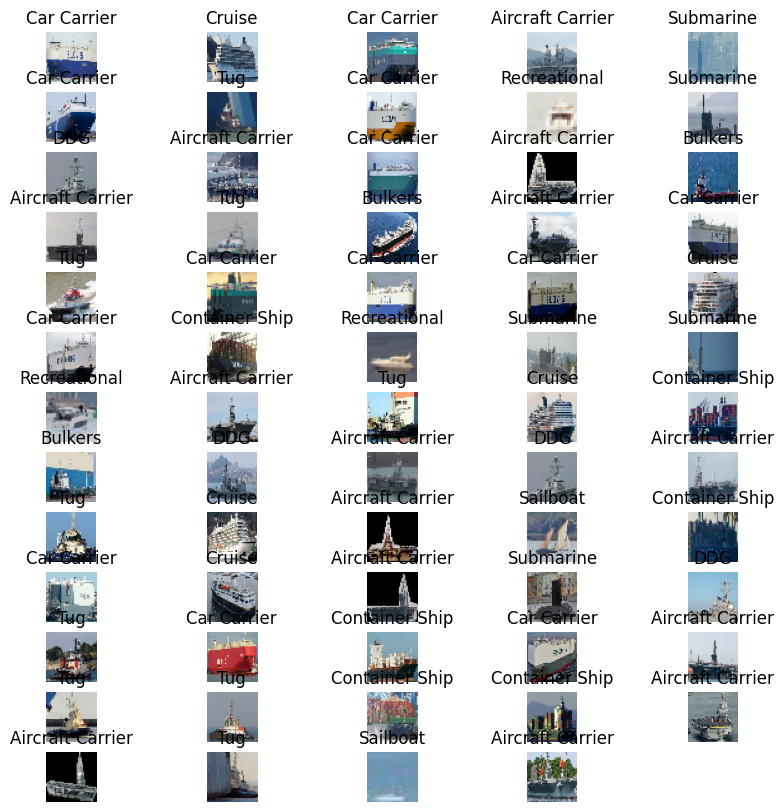

In [173]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(images.shape[0]):
        ax = plt.subplot(images.shape[0] // 5 + 1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[np.argmax(labels[i])])
        plt.axis("off")

In [115]:
class_counts_train = {}
for images, labels in train_ds:
    for label in labels.numpy():
        class_index = label.argmax()  # Get the class index with the highest probability
        if class_index not in class_counts_train:
            class_counts_train[class_index] = 0
        class_counts_train[class_index] += 1

# Count the number of objects in each class for validation dataset
class_counts_validation = {}
for images, labels in val_ds:
    for label in labels.numpy():
        class_index = label.argmax()
        if class_index not in class_counts_validation:
            class_counts_validation[class_index] = 0
        class_counts_validation[class_index] += 1

# Print or use the class counts as needed
print("Training Dataset Class Counts:")
print(class_counts_train)

print("Validation Dataset Class Counts:")
print(class_counts_validation)

Training Dataset Class Counts:
{0: 792, 2: 1772, 3: 832, 4: 778, 7: 328, 1: 479, 8: 746, 9: 803, 5: 863, 6: 236}
Validation Dataset Class Counts:
{9: 77, 3: 82, 0: 74, 8: 72, 5: 84, 2: 179, 1: 23, 4: 72, 7: 15, 6: 11}


In [174]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [175]:
inputs = Input(shape=(img_height, img_width, 3))

x = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255) (inputs)

x = Conv2D(filters = 8, kernel_size = (3,3),padding = 'Same', 
           activation ='gelu', kernel_regularizer=l2(0.001)) (x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2)) (x)
x = Dropout(0.5) (x)
x = BatchNormalization() (x)

x = Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
           activation ='gelu', kernel_regularizer=l2(0.001)) (x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2)) (x)
x = Dropout(0.5) (x)
x = BatchNormalization() (x)


# top
x = Flatten() (x)
x = Dense(32, activation = "gelu") (x)
x = BatchNormalization() (x)
x = Dropout(0.5) (x)
outputs = Dense(10, activation='softmax') (x)

model = Model(inputs=inputs, outputs=outputs)

In [176]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [177]:
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 40, 40, 3)]       0         
                                                                 
 rescaling_13 (Rescaling)    (None, 40, 40, 3)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 40, 40, 8)         224       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 20, 20, 8)        0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 20, 20, 8)         0         
                                                                 
 batch_normalization_40 (Bat  (None, 20, 20, 8)        32        
 chNormalization)                                         

In [178]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)
filepath = 'checkpoints/model_{epoch:02d}-{val_loss:.2f}.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
    save_freq="epoch",
    initial_value_threshold=1.
)

In [179]:
epochs=50
history = model.fit(
    train_ds,
    callbacks=[checkpoint, early_stopping],
    validation_data=val_ds,
    epochs=epochs,
    workers=10,
    use_multiprocessing=True
)

Epoch 1/50
119/120 [============================>.] - ETA: 0s - loss: 2.5001 - accuracy: 0.2513
Epoch 1: val_loss did not improve from 1.00000
120/120 [==============================] - 6s 8ms/step - loss: 2.4942 - accuracy: 0.2526 - val_loss: 2.3561 - val_accuracy: 0.2467
Epoch 2/50
114/120 [===========================>..] - ETA: 0s - loss: 1.7040 - accuracy: 0.4577
Epoch 2: val_loss did not improve from 1.00000
120/120 [==============================] - 1s 5ms/step - loss: 1.6985 - accuracy: 0.4602 - val_loss: 2.3210 - val_accuracy: 0.2206
Epoch 3/50
118/120 [============================>.] - ETA: 0s - loss: 1.4594 - accuracy: 0.5357
Epoch 3: val_loss did not improve from 1.00000
120/120 [==============================] - 1s 5ms/step - loss: 1.4568 - accuracy: 0.5364 - val_loss: 1.6913 - val_accuracy: 0.4441
Epoch 4/50
117/120 [============================>.] - ETA: 0s - loss: 1.3229 - accuracy: 0.5755
Epoch 4: val_loss did not improve from 1.00000
120/120 [==========================

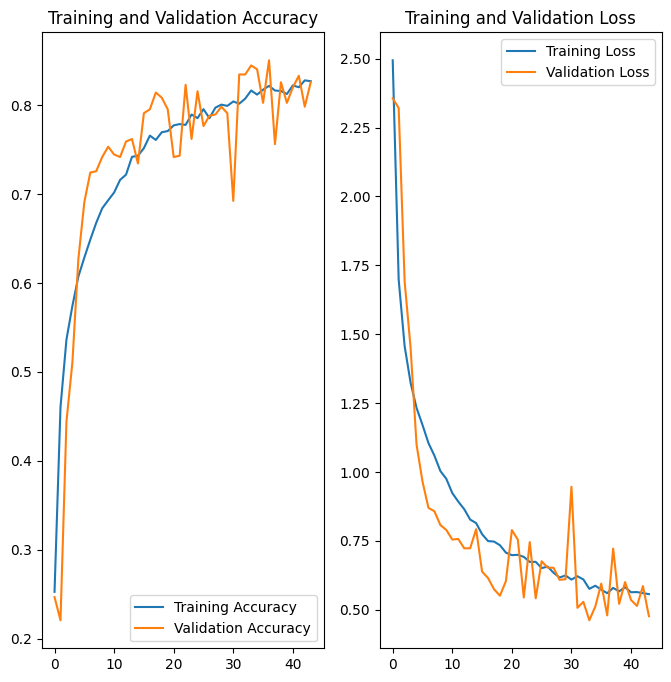

In [180]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [181]:
results = model.evaluate(test_ds)
print("test loss, test acc:", results)

6/6 [==============================] - 0s 47ms/step - loss: 0.4253 - accuracy: 0.8661
test loss, test acc: [0.42531684041023254, 0.8661417365074158]


In [182]:
y_pred = np.argmax(model.predict(test_ds), axis=-1)

predictions = []
labels = np.array([])
for image, label in test_ds:
    predictions = np.concatenate([predictions, np.argmax(model.predict(image), axis=-1)])
    labels = np.concatenate([labels, np.argmax(label.numpy(), axis=-1)])

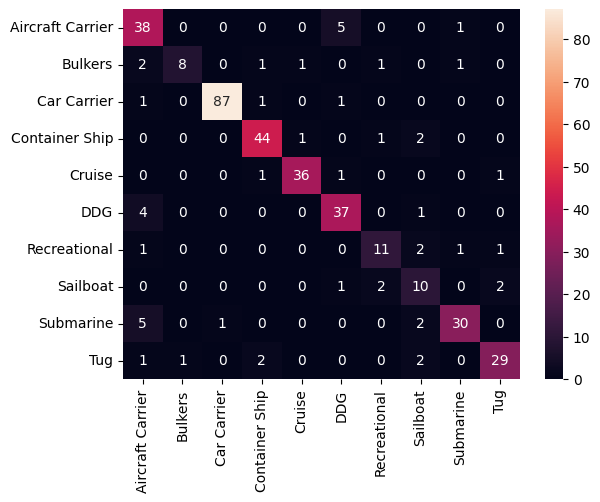

In [183]:
conf = confusion_matrix(labels, predictions)
_ = sns.heatmap(conf, annot=True, yticklabels=class_names, xticklabels=class_names)

In [184]:
from sklearn.metrics import classification_report

print(classification_report(labels, predictions))

              precision    recall  f1-score   support

         0.0       0.73      0.86      0.79        44
         1.0       0.89      0.57      0.70        14
         2.0       0.99      0.97      0.98        90
         3.0       0.90      0.92      0.91        48
         4.0       0.95      0.92      0.94        39
         5.0       0.82      0.88      0.85        42
         6.0       0.73      0.69      0.71        16
         7.0       0.53      0.67      0.59        15
         8.0       0.91      0.79      0.85        38
         9.0       0.88      0.83      0.85        35

    accuracy                           0.87       381
   macro avg       0.83      0.81      0.82       381
weighted avg       0.87      0.87      0.87       381

